# Taking positive expected value bets

Expected value (EV) is when the calculated probability is greater than the implied probability. The calculated odds can be considered the "true line" should be, and the difference between that and the implied odds is the extra value. This can be applied in the worlds of trading and investing, along with in our case sports betting.

Takine a positive EV bet does not mean it will actually hit. EV gives you an advantage over time as the positive EV value with be realized after a series of bets. There is always the variable of randomness that can prevent predictability around individual bets.

We are implying the probabilities from the lines, but what the line is <i>explicitly</i> telling us is our reward-to-risk ratio (for each unit of risk, how much do we win?). If we have a bet that's +300, that's a 3 to 1 payout, and a 25% implied probability (100/(300+100)). 25% is also our breakeven point on any 3-1 bet. Which means, if we consistently took +300 bets, we would need a 25% win rate to breakeven. If we are able to push our win rate above 25%, even to say 27%, then we've developed an edge and positive EV.

This also means, that by definition, just taking sports bets at random, your EV is 0 and you are expected to lose no money and gain no money assuming Vegas is right over the long run, which is usually the fair assumption.

We'll only be covering a single player prop here, since this post will end up being quite long. We'll be looking at the O/U for Jalen Hurts pass attempts, which is currently +100 for over 31.5 attempts on DraftKings. However, you're welcome to also apply this code to other player props that might be well-modeled by the distribution we'll discuss (Poisson), or even other types of props that may be well-modeled by different distributions (ie. Anytime TD scorer and a Binomial distribution).

In [ ]:
!pip install nfl-data-py

In [ ]:
import nfl_data_py as nfl
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore')

random = np.random.default_rng(42)

plt.style.use('ggplot')

To simplify, we are taking the odds from just one sportsbook (Fanduel).

In [ ]:
hurts_pa_ou = 31.5
hurts_pa_line = +100 # for the over

`implied_probability` takes two parameters: `money_line` and `round_n`, with `round_n` defaulting to 2 if not provided. It calculates the implied probability of a sports event outcome based on the given money line, where negative values favor the outcome and positive values indicate the outcome as an underdog.


In [ ]:
def implied_probability(money_line, round_n=2):
    if money_line < 0:
        return round(money_line / (money_line - 100), round_n)
    else:
        return round(1 - (money_line / (money_line + 100)), round_n)

ip_x = implied_probability(hurts_pa_line)
print(f'Implied probability of over {hurts_pa_ou} pass attempts for Hurts in the Super Bowl is: ', ip_x)

Implied probability of over 31.5 pass attempts for Hurts in the Super Bowl is:  0.5


Using nfl-data-py, we can grab Hurts weekly data, specifically grabbing the `attempts` column from his DataFrame, and convert it to an array using the `values` attribute.

In [ ]:
#load our data for hurts
weekly_data = nfl.import_weekly_data(years=range(2021, 2023), columns=['player_name', 'attempts'])
hurts_pa = weekly_data.loc[weekly_data['player_name'] == 'J.Hurts'].attempts.values

hurts_pa

Downcasting floats.


array([35, 23, 39, 48, 37, 26, 34, 14, 17, 23, 24, 31, 26, 29, 26, 43, 32,
       31, 35, 25, 36, 25, 28, 27, 26, 25, 28, 39, 31, 37, 35, 24, 25, 38],
      dtype=int32)

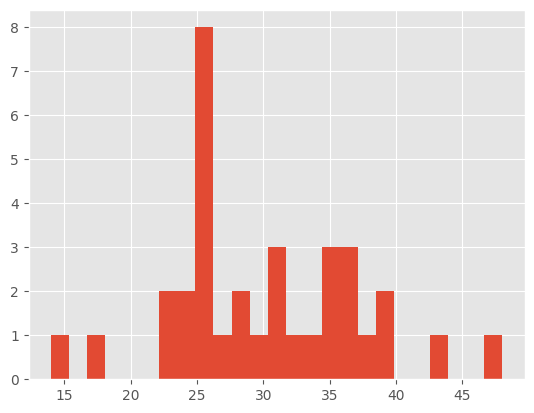

In [ ]:
plt.hist(hurts_pa, bins=25);

In [ ]:
print('Sample size: ', len(hurts_pa))
print('Mean: ', hurts_pa.mean())
print('Median: ', np.median(hurts_pa))
print('Standard deviation: ', hurts_pa.std())

Sample size:  34
Mean:  30.058823529411764
Median:  28.5
Standard deviation:  7.128819622079959


# Bootstrap Resampling

This plots Hurts passing attempt data and prints out some summary statistics to better understand how his pass attempts are distributed. Of these statistics the mean is most useful for our analysis.

Bootstrap resampling is a method for establishing a confidence interval for the parameters in shaping our data distribution. It is particularly useful in scenarios where precise estimates of statistics are necessary, but the ability to gather additional samples is either impractical or expensive.

In this approach, we repeatedly draw samples from our dataset, mimicking Hurts' pass attempt outcomes, with replacement (allowing duplicates) for n iterations. Here, n corresponds to the length of our dataset, representing the available samples of actual pass attempts in his career. For each bootstrapped dataset, we calculate the desired statistic, such as the mean, storing these results in a separate array.

After conducting multiple rounds of this process, we look at the collection of summary statistics we've generated. This dataset allows us to explore a range of possibilities and have a better understanding of the parameter we are seeking, or in this case the mean.

In [ ]:
# sampling with replacement first
xs = np.array([])
n_simulations = 10_000

for _ in range(n_simulations):
    boot_x = np.random.choice(hurts_pa, size=len(hurts_pa), replace=True).mean()
    xs =  np.append(xs, boot_x)

xs

array([31.58823529, 29.88235294, 29.55882353, ..., 31.61764706,
       30.97058824, 30.38235294])

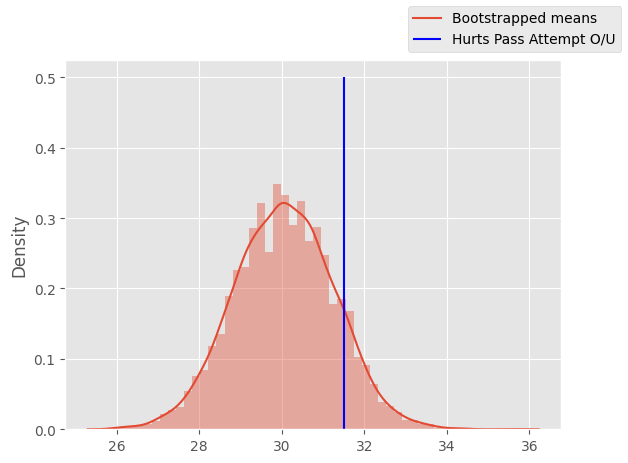

In [ ]:
sns.distplot(xs);
plt.gca().vlines(x=hurts_pa_ou, ymin=0, ymax=0.5, color='blue');
plt.gcf().legend(['Bootstrapped means', 'Hurts Pass Attempt O/U']);

#saving this for later
kde_data_x, kde_data_y = plt.gca().lines[0].get_data()

The chart illustrates the range of bootstrapped means from random re-sampling of Jalen Hurts' career. Observing the data, there's a slight possibility that Jalen Hurts' long-term passing attempts could peak at 34 or dip to 24. Although this seems improbable given Jalen Hurts' past performances, it can't be ruled out. It's more probable that his genuine long-term mean aligns with his present career average of 29, and the data spread supports this.


In [ ]:
lower_bound, upper_bound = np.quantile(xs, 0.025), np.quantile(xs, 0.975)
lower_bound, upper_bound

(27.676470588235293, 32.411764705882355)

We can be fairly certain that Hurts long-run passing attempt average lies somewhere between 27.39 and 32.21 (only 2.5% of values fell below the former, and only 2.5% of values fell above the latter).


# Modeling Pass Attempts

Next, we're going to model Jalen Hurts' pass attempts using a Poisson distribution. A Poisson distribution is a discrete probability distribution where the timing of events are independent from each other. It has one parameter, lambda, which is the rate at which events occur per unit time. pass attempts per game is the lambda for this. We'll start off by using Hurts mean pass attempts / gm, but then we'll bring in the results of our bootstrap to model different, but also-likely, values for lambda.

First, we calculate long-run frequency of pass attempts / gm with the lower and upper bounds of our confidence interval for the bootstrap above.

In [ ]:
#drawing from a Poisson distribution
poisson_arr = np.random.poisson(lam=hurts_pa.mean(), size=n_simulations)

calculated_probability = sum(poisson_arr > hurts_pa_ou) / n_simulations
print('Calculated probability of the over hitting: ', calculated_probability)
print ('Calculated probability of the under hitting: ', 1 - calculated_probability)
if calculated_probability > ip_x:
    print('Take the over')
else:
    print('Take the under')

Calculated probability of the over hitting:  0.3874
Calculated probability of the under hitting:  0.6126
Take the under


Now calculate a "best-case" calculated probability and "worst-case" calculated probability for Hurts using a lower bound of 2.5% and upper bound of 97.5%, or 95% confidence interval.

In [ ]:
poisson_arr_lower_bound = np.random.poisson(lam=lower_bound, size=n_simulations)
calculated_probability_lower_bound = sum(poisson_arr_lower_bound > hurts_pa_ou) / n_simulations
print(round(calculated_probability_lower_bound, 4), round(ip_x, 4))
print(round(1 - calculated_probability_lower_bound, 4), round(ip_x, 4))

0.2287 0.5
0.7713 0.5


In [ ]:
poisson_arr_upper_bound = np.random.poisson(lam=upper_bound, size=n_simulations)
calculated_probability_upper_bound = sum(poisson_arr_upper_bound > hurts_pa_ou) / n_simulations
print(round(calculated_probability_upper_bound, 4), round(ip_x, 4))
print(round(1 - calculated_probability_upper_bound, 4), round(ip_x, 4))

0.5562 0.5
0.4438 0.5


In the "worst-case" scenario, which refers to the maximum limit of our confidence range, the likelihood of exceeding the target is 53%, in comparison to the 50% anticipated probability. This means that the under is more likely to be taken in this case.

You can actually show how the edge (the spread between calculated probability and implied probability, also our profit margin) changes given a change in the estimate for Hurts' true pass attempts / gm:

In [ ]:
def calculate_probability(lam, n_simulations=200_000):
    """
    Function that calculates probability of hitting the over for a given lambda, with default n_simulations=200,000
    """
    draws = np.random.poisson(lam=lam, size=n_simulations)
    return sum(draws > hurts_pa_ou) / n_simulations

quantiles = np.arange(1, len(kde_data_x)) / len(kde_data_x)
y = np.array([calculate_probability(np.quantile(xs, i/len(quantiles))) for i in range(1, len(quantiles) + 1)])
x = np.array([np.quantile(xs, quantile) for quantile in quantiles])

We end up with the data here that contains our calculated probability for each reasonably likely  Hurts' pass attempt / gm. This is plotted, along with the implied probability from the money line (When calculated probability < implied probability, then the under is +EV and over is -EV, and when calculated probability > implied probability, then the under is -EV and the over is +EV).

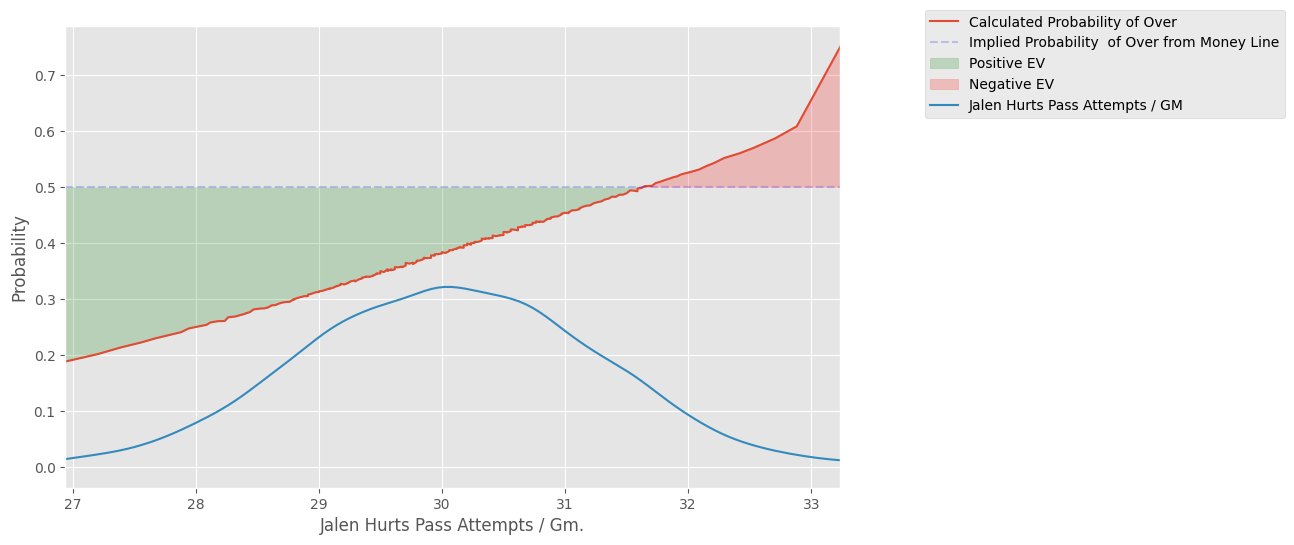

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(x, y);
ax.hlines(xmin=x.min(), xmax=x.max(), y=ip_x, color='blue', alpha=0.2, linestyle='--');
ax.fill_between(
    x, y, ip_x, color='green', alpha=0.2, where=y<ip_x
)
ax.fill_between(
    x, y, ip_x, color='red', alpha=0.2, where=y>ip_x*0.99
);

ax.set_ylabel('Probability')
ax.set_xlabel('Jalen Hurts Pass Attempts / Gm.');

ax.plot(kde_data_x, kde_data_y);
ax.set_xlim([x.min(), x.max()]);

ax.legend(['Calculated Probability of Over', 'Implied Probability  of Over from Money Line', 'Positive EV', 'Negative EV', 'Jalen Hurts Pass Attempts / GM'], bbox_to_anchor=(1.1, 1.05));

The blue line is the bootstrapped means distribution. It is labeled that as "Jalen Hurts pass attempts/GM". The dotted line marks the implied probability of over 31.5 pass attempts hitting according to the given line. The solid red line is the calculated probability of the over hitting at each likely Hurts' pass attempt per game.

Frim this graph, We can see that as Jalen Hurts' pass attempts / gm number gets smaller and smaller, the edge widens. Going farther on the right side of the distribution, we can see our edge narrows until it eventually turns -EV.

We can also see here that our under bet tilts to -EV after around 31.5. This makes sense given that was the over/under. Therefore, we can get the probability of our bet being +EV from the result our bootstrap.

In [ ]:
probability_bet_is_positive_ev = sum(xs < hurts_pa_ou) / len(xs)
print('Probability the under is +EV: ', probability_bet_is_positive_ev)

Probability the under is +EV:  0.8793


This shows the likelihood of the under hitting is somewhere around 63%, with a confidence interval of somewhere between 46% and 78%, and a 91% chance that the bet is +EV.

The pass defense is the main thing not being taken into account. This could affect the odds positively or negatively depending. Ignoring those factors though, is seems the over is more likely to happen in this case and is therefore the safer option.